# Transfer Learning on Fashion MNIST
---

## Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import torch
import torchvision

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

## Global Configs

In [4]:
size = 224
DATAPATH = "../data/FashionMNIST/"

In [5]:
is_sample = False
if is_sample: PATH = DATAPATH+'sample'
else: PATH = DATAPATH

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.backends.cudnn.enabled

True

## Load Dataset

In [8]:
data = torchvision.datasets.FashionMNIST(DATAPATH,
                                         download=True)

In [9]:
test = torchvision.datasets.FashionMNIST(DATAPATH,
                                         train=False)

## Data Exploration

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Let's look at the class distribution...

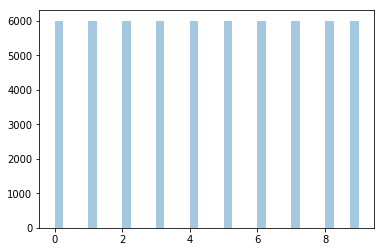

In [10]:
sns.distplot(data.train_labels,kde=False)

We find an equal distribution for all classes i.e. 6000 for all 10 fashion classes

Let's look at the images...

In [11]:
def plot_images(imgs, figsize=(12,6), titles=None, maintitle=None):
    fig = plt.figure(figsize=figsize)
    imgs = np.array(imgs)
    if maintitle is not None:
        plt.suptitle(maintitle, fontsize=16)
    imgs_len = len(imgs)
    for idx in range(imgs_len):
        subplt = fig.add_subplot(1, imgs_len, idx+1)
        subplt.axis('Off')
        if titles is not None:
            subplt.set_title(titles[idx], fontsize=16)
        plt.imshow(imgs[idx], cmap='gray')

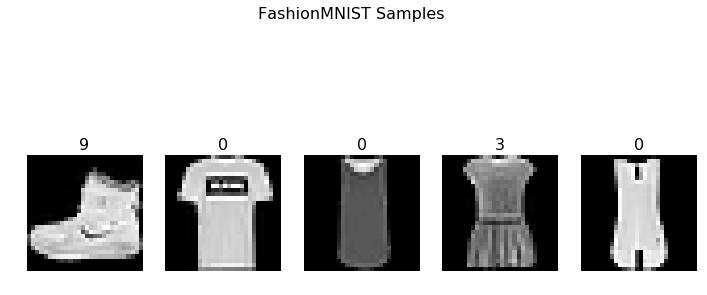

In [12]:
plot_images(data.train_data[:5],
            titles=data.train_labels[:5],
            maintitle='FashionMNIST Samples')

In [13]:
data.train_data.shape

torch.Size([60000, 28, 28])

Hence, we have 60,000 images of dimensions 28 by 28

In [10]:
labels_dict = {0: 'Top', 1: 'Trouser', 2: 'Pullover', 
               3: 'Dress', 4: 'Coat', 5: 'Sandal',
               6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Boot'}

## Data Preprocessing

Here we split the dataset into sample_train, sample_valid, train and valid sets.

Sample dataset is for testing on local machine before training on the cloud. It is set by the global config SAMPLE.

In [15]:
# sample_train = data.train_data[:1000]
# sample_train_labels = data.train_labels[:1000]
# sample_valid = data.train_data[1000:1100]
# sample_valid_labels = data.train_labels[1000:1100]

In [16]:
train = data.train_data[:50000]
train_labels = data.train_labels[:50000]
valid = data.train_data[50000:60000]
valid_labels = data.train_labels[50000:60000]

Create data directory structure

In [17]:
os.mkdir(DATAPATH+'train')
os.mkdir(DATAPATH+'valid')

FileExistsError: [Errno 17] File exists: '../data/FashionMNIST/train'

In [18]:
# a sample of the dataset
# os.mkdir(DATAPATH+'sample/train')
# os.mkdir(DATAPATH+'sample/valid')

Populate data directories

In [19]:
def imwrite_dir(images, labels, path):
    # make directory structure for labels or classes
    for label in np.unique(labels):
        os.mkdir(path+str(label))
    # put the images in the proper label directories
    for i in range(images.shape[0]):
        image = images[i]
        filepath = path+str(labels[i])+'/'+str(i)+'.jpg'
        torchvision.utils.save_image(image,
                                     filepath)

In [20]:
# imwrite_dir(sample_train, sample_train_labels, DATAPATH+'sample/train/')
# imwrite_dir(sample_valid, sample_valid_labels, DATAPATH+'sample/valid/')


In [21]:
imwrite_dir(train, train_labels, DATAPATH+'train/')
imwrite_dir(valid, valid_labels, DATAPATH+'valid/')

FileExistsError: [Errno 17] File exists: '../data/FashionMNIST/train/0'

**Sanity check for data distribution**

In [22]:
! ls ../data/FashionMNIST/train/0 | wc -l
! ls ../data/FashionMNIST/train/1 | wc -l
! ls ../data/FashionMNIST/train/5 | wc -l
! ls ../data/FashionMNIST/train/9 | wc -l

4977
5012
5004
4979


In [23]:
! ls ../data/FashionMNIST/valid/0 | wc -l
! ls ../data/FashionMNIST/valid/1 | wc -l
! ls ../data/FashionMNIST/valid/5 | wc -l
! ls ../data/FashionMNIST/valid/9 | wc -l

1023
988
996
1021


## Training Model [resnet34]

In [19]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH,tfms=tfms_from_model(arch, size))

In [20]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.59579    0.459351   0.830414  
    1      0.535873   0.425754   0.844944  



[0.42575356, 0.8449442675159236]

In [23]:
learn.save('resnet34-train_valid')

## Model Analysis

In [24]:
learn.load('resnet34-sample')

In [25]:
log_preds=learn.predict()
log_preds.shape

(10000, 10)

In [26]:
log_preds[:5]

array([[ -0.3408 ,  -8.96755,  -5.81225,  -2.67534,  -4.84085, -11.03217,  -1.56664, -11.63359,  -9.01889,
        -11.67291],
       [ -0.02209,  -7.26183,  -4.97118,  -4.8595 ,  -8.38599, -12.07985,  -5.1748 , -13.61431,  -7.4938 ,
        -11.41757],
       [ -0.01932, -11.85231,  -7.59891,  -4.70157,  -8.99029,  -8.4608 ,  -4.69603, -12.3272 ,  -9.60526,
        -11.60536],
       [ -0.00894, -10.84166,  -8.04645,  -6.77204,  -8.92337, -11.85935,  -4.92604, -13.90546, -11.24127,
        -13.27043],
       [ -0.00164, -12.69415,  -7.22549,  -7.82598, -11.4448 , -14.22698,  -7.66379, -15.51375, -10.36539,
        -16.76541]], dtype=float32)

In [27]:
preds = np.argmax(log_preds, axis=1)
preds[-5:]

array([0, 9, 9, 9, 9])

In [28]:
all_probs = {}
for key, label in labels_dict.items():
    all_probs[key] = np.exp(log_preds[:,key])

** Analysis Utilities**

In [11]:
def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y)==is_correct)

def most_by_mask(mask):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    return most_by_mask(((preds == data.val_y)==is_correct)
                        & (data.val_y == y))

** Plot Utilities **

In [12]:
def plots(ims, figsize=(12,6), rows=1, titles=None, main_title=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
    plt.suptitle(main_title, fontsize=24)


In [13]:
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+'/'+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [(data.val_y[x], preds[x]) for x in idxs]
    title=title+'\n(True Label, Predicted Label)'
    return plots(imgs, rows=1, titles=title_probs,
                 figsize=(16,8), main_title=title)

### A few correct labels at random

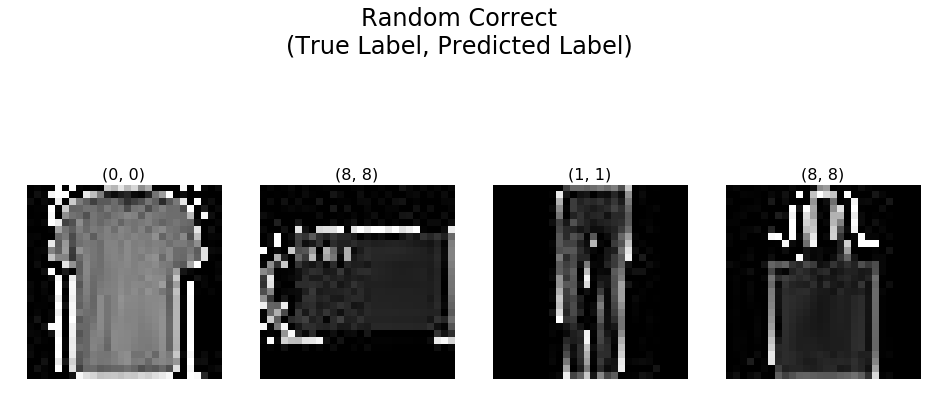

In [33]:
correct_idx = rand_by_correct(is_correct=True)
probs = all_probs[0]
plot_val_with_title(correct_idx, "Random Correct")

### A few incorrect labels at random

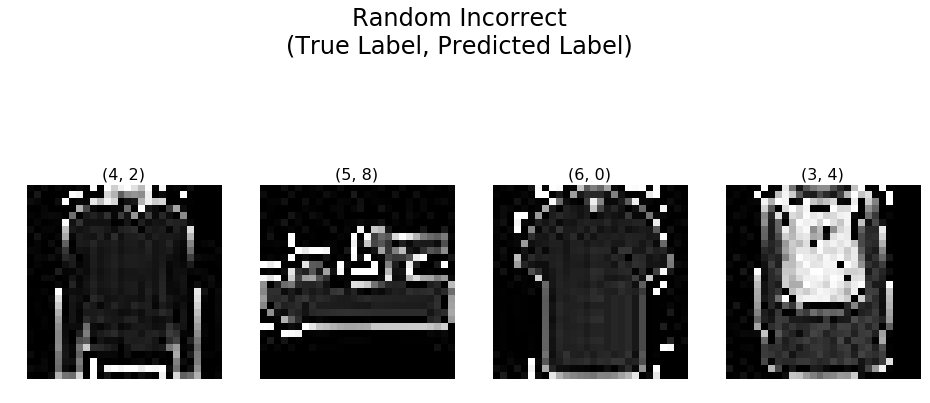

In [34]:
incorrect_idx = rand_by_correct(is_correct=False)
probs = all_probs[0]
plot_val_with_title(incorrect_idx, "Random Incorrect")

** The most correct labels of each class**

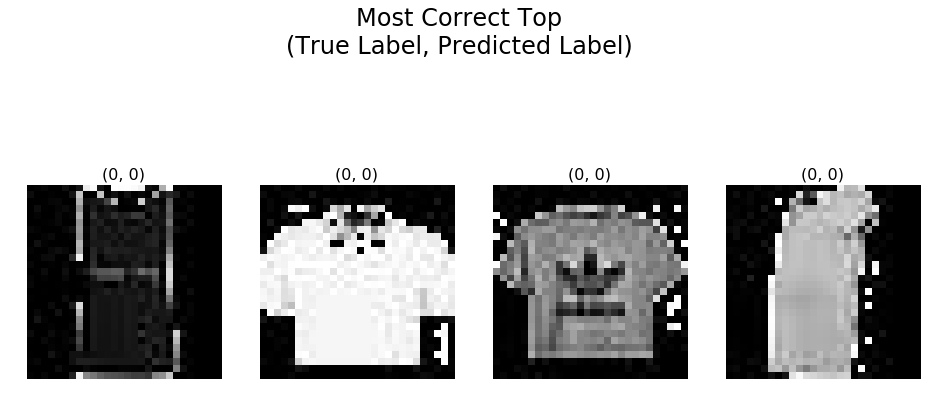

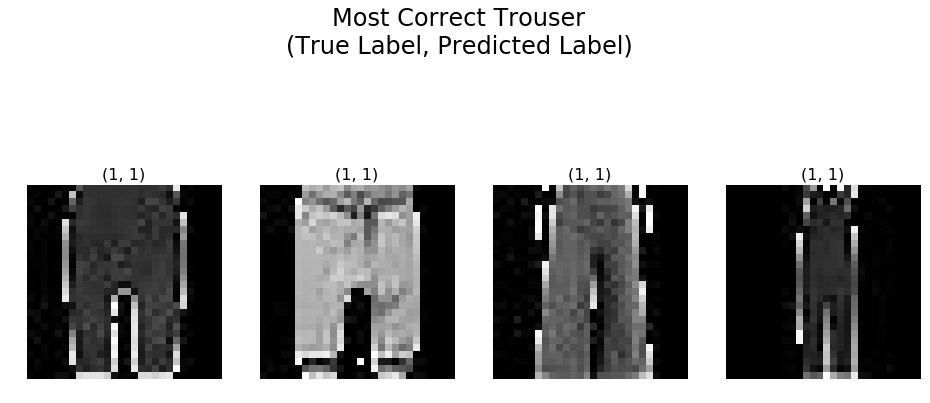

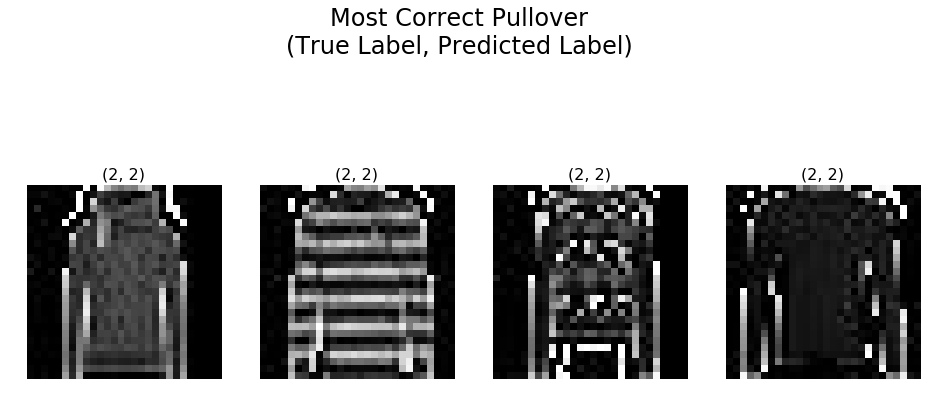

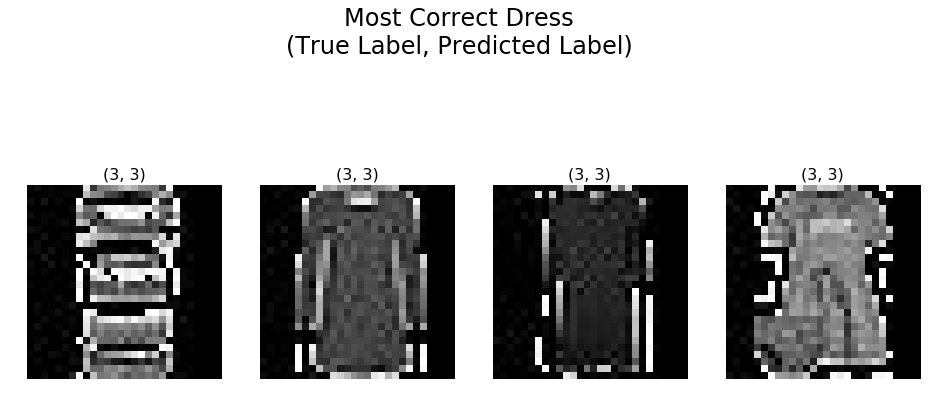

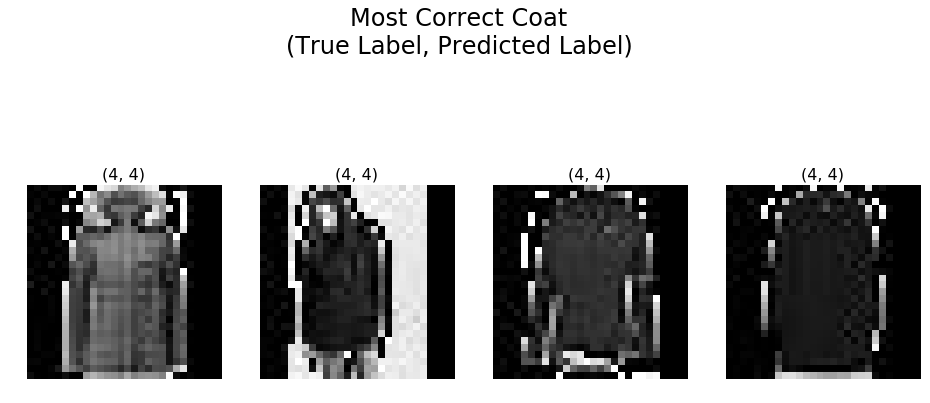

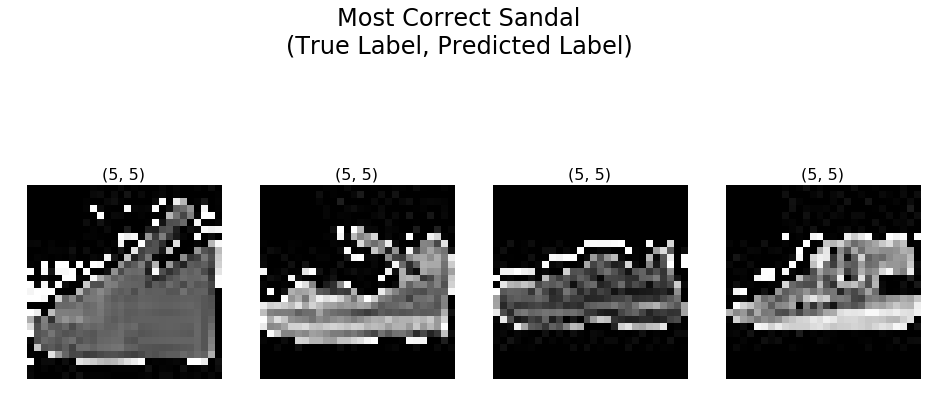

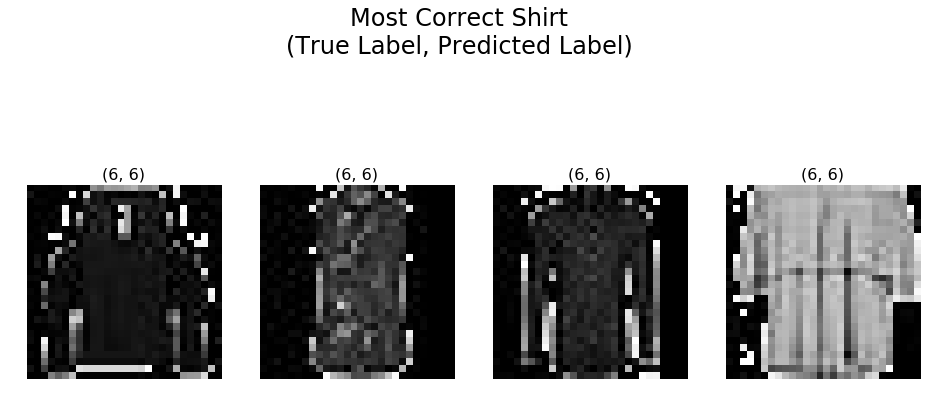

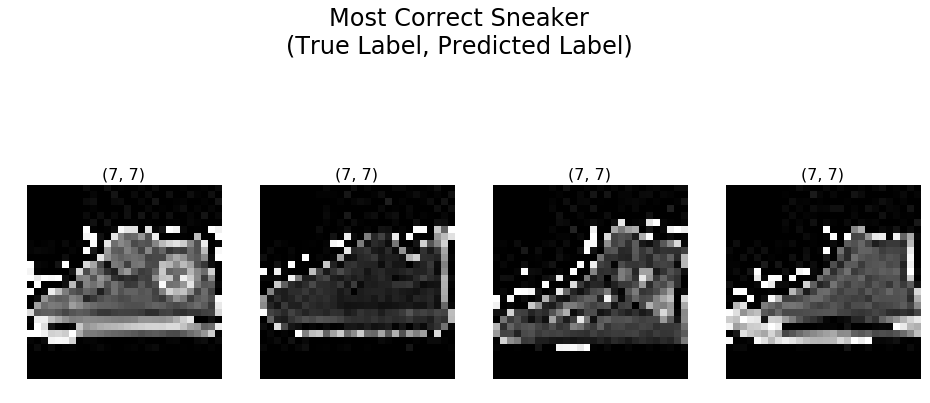

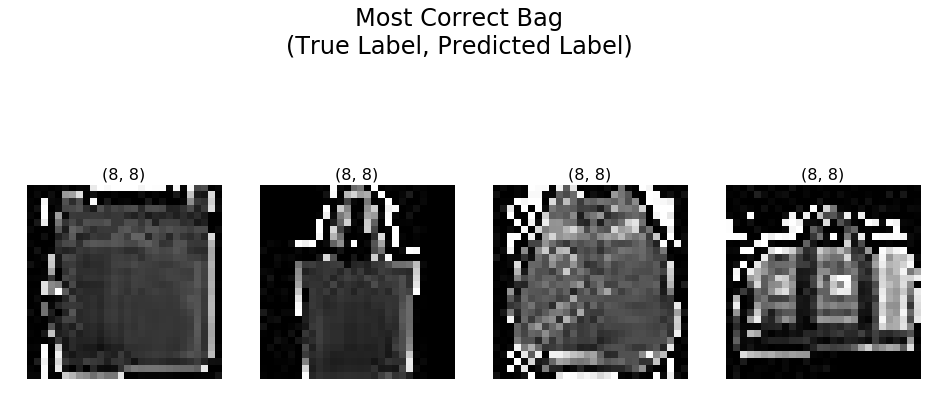

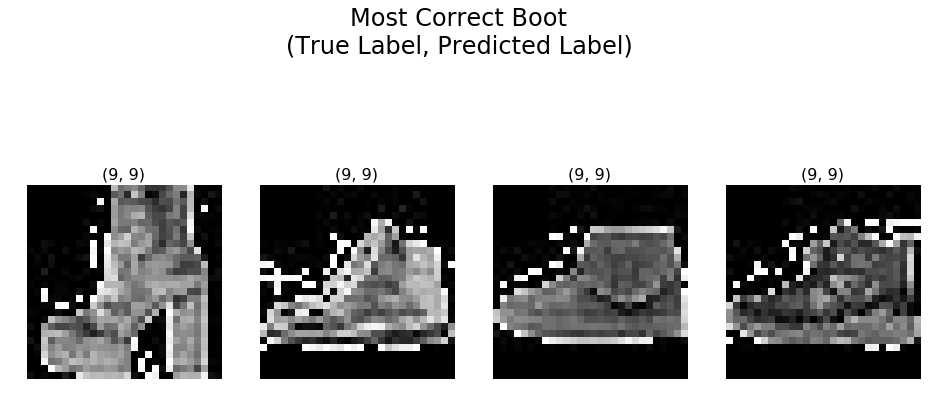

In [35]:
for key, label in labels_dict.items():
    probs=all_probs[key]
    plot_val_with_title(most_by_correct(key, True),
                        "Most Correct {}".format(label))

### The most incorrect labels of each class

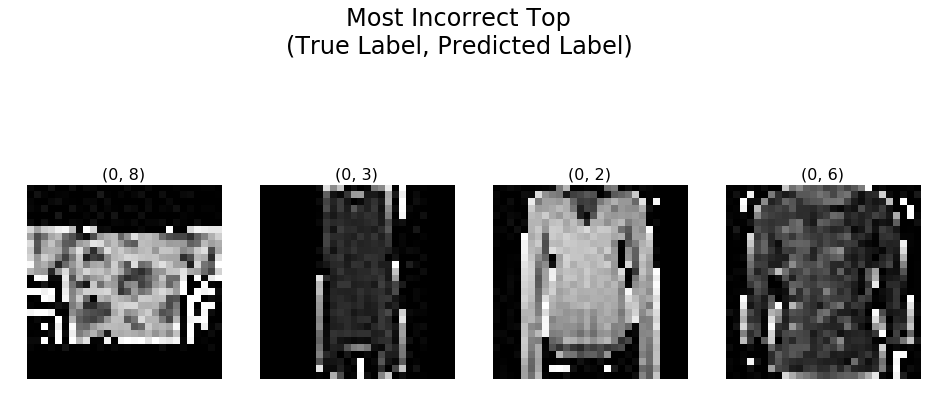

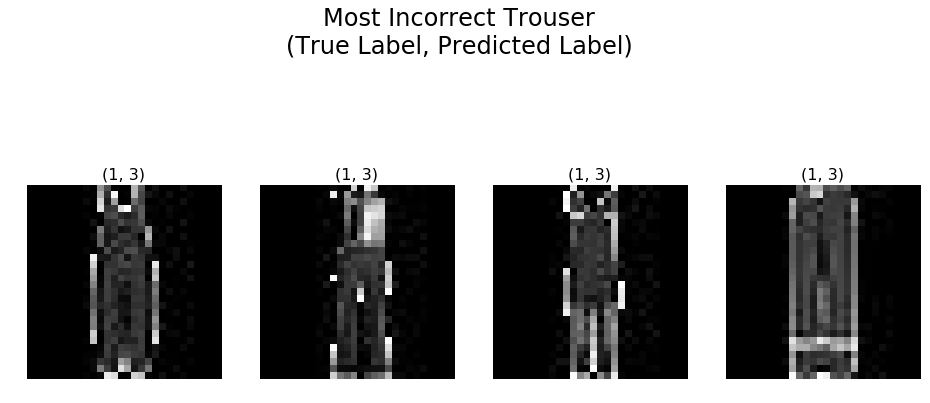

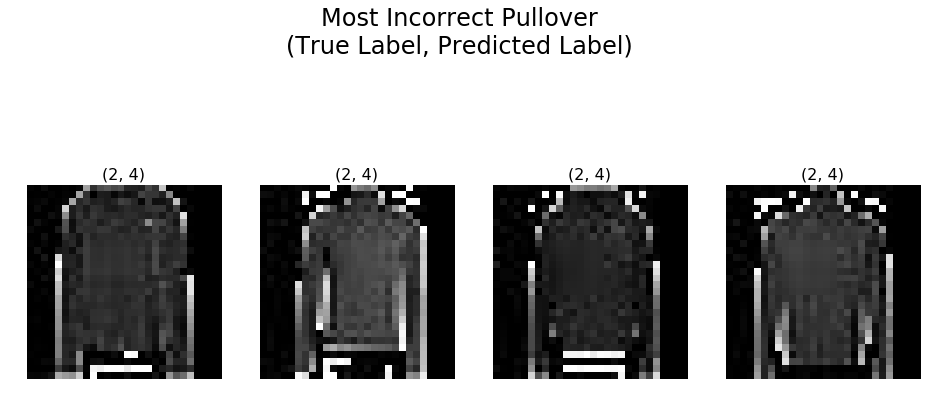

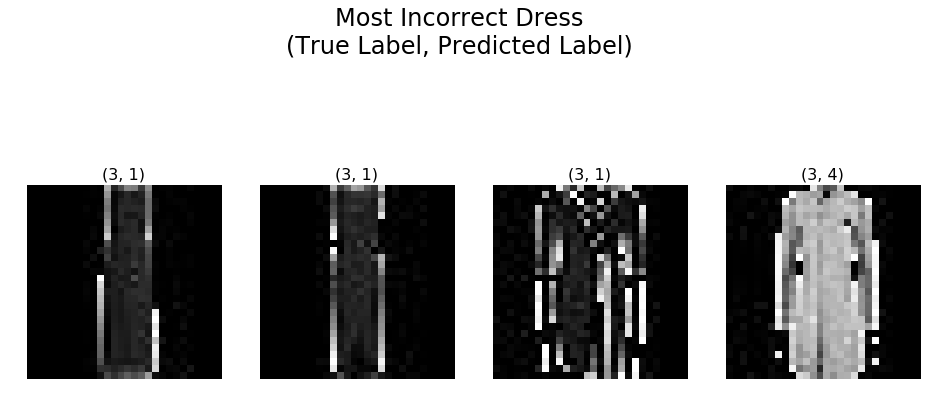

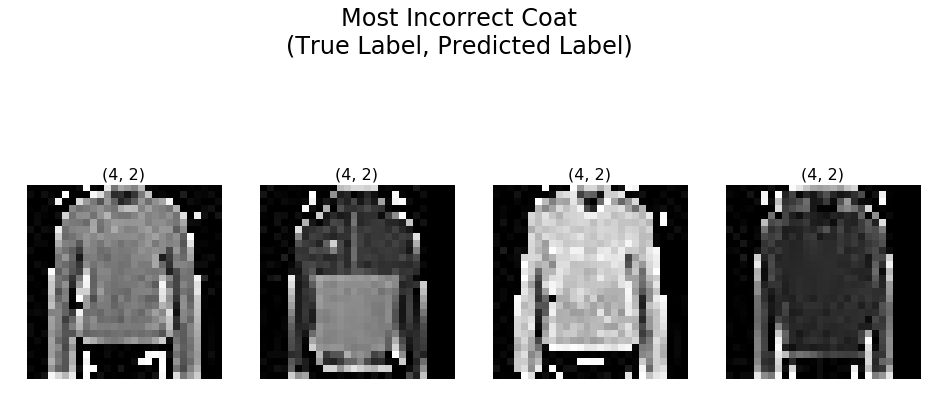

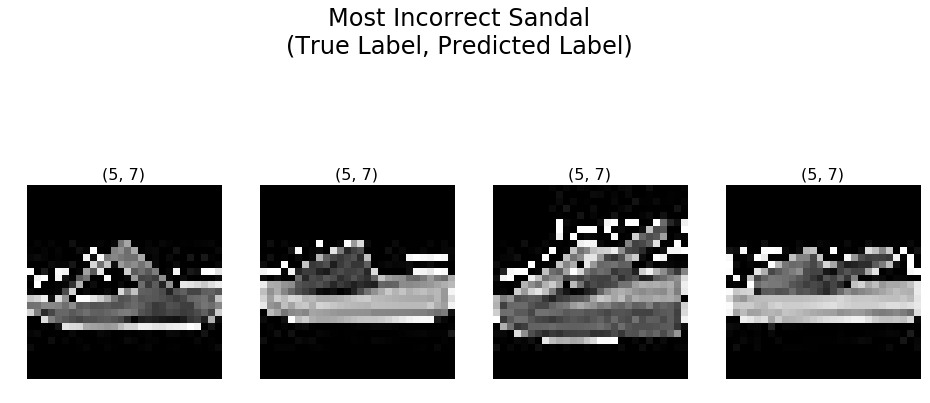

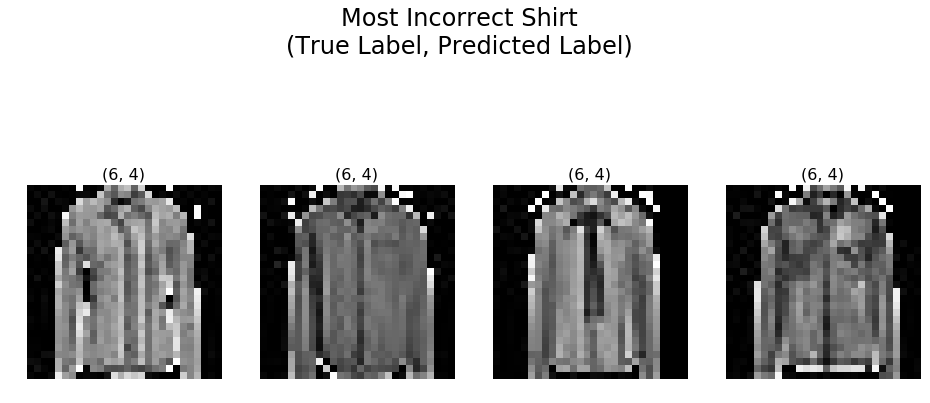

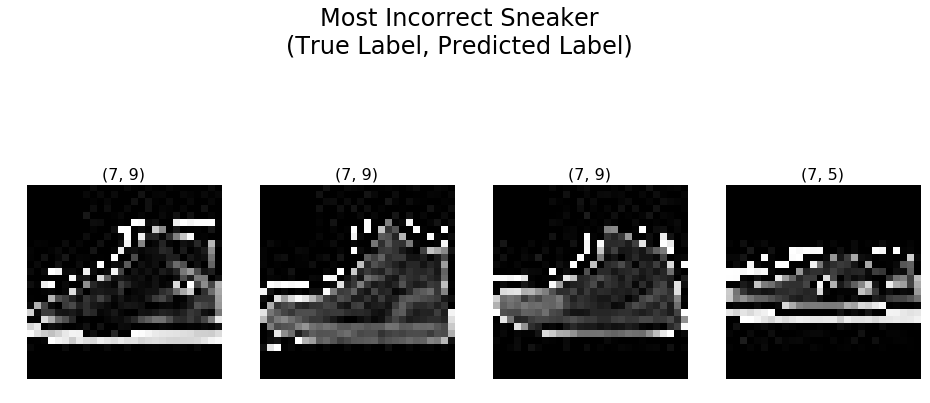

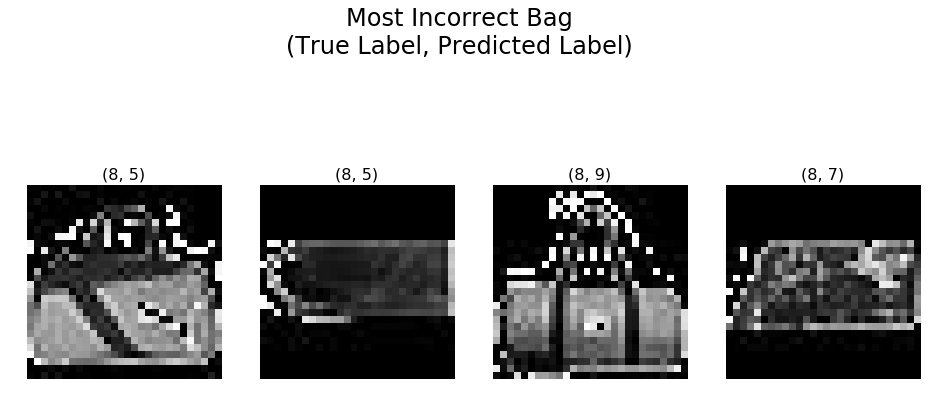

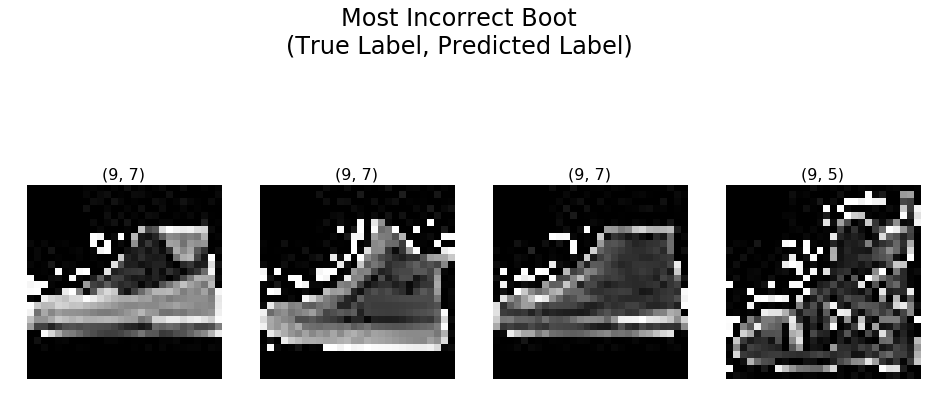

In [36]:
for key, label in labels_dict.items():
    probs=all_probs[0]
    plot_val_with_title(most_by_correct(key, False),
                        "Most Incorrect {}".format(label))

## The most uncertain labels for each class

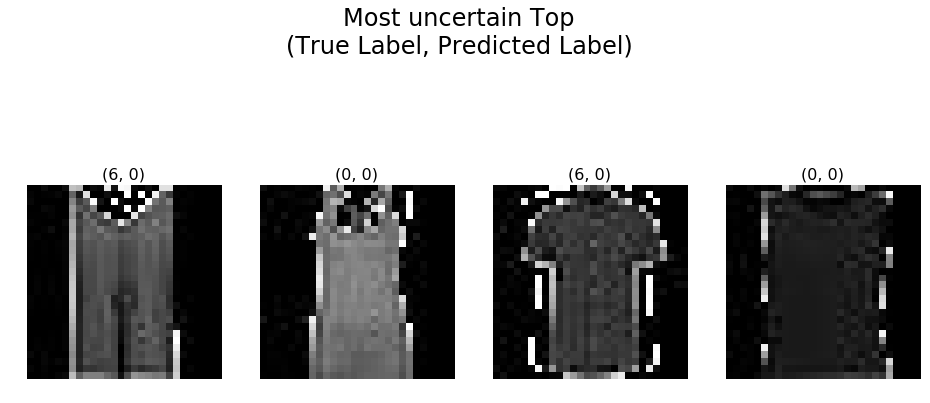

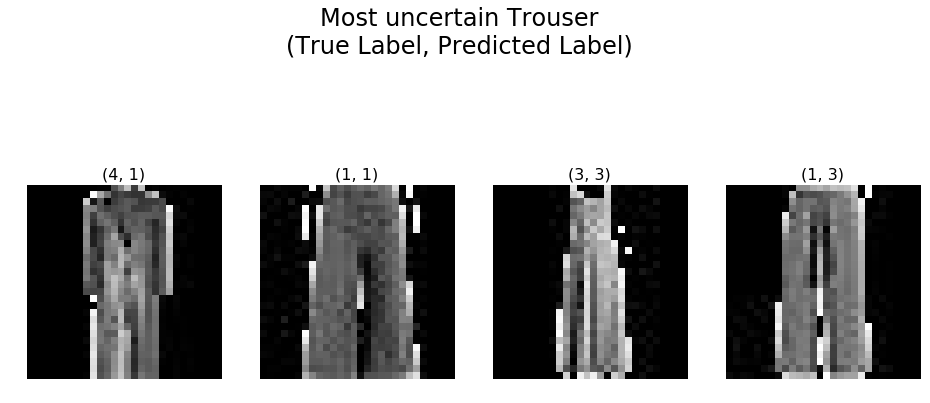

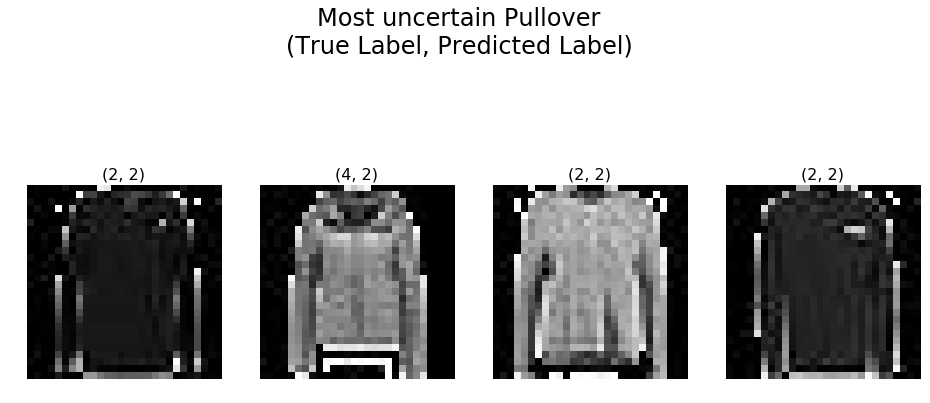

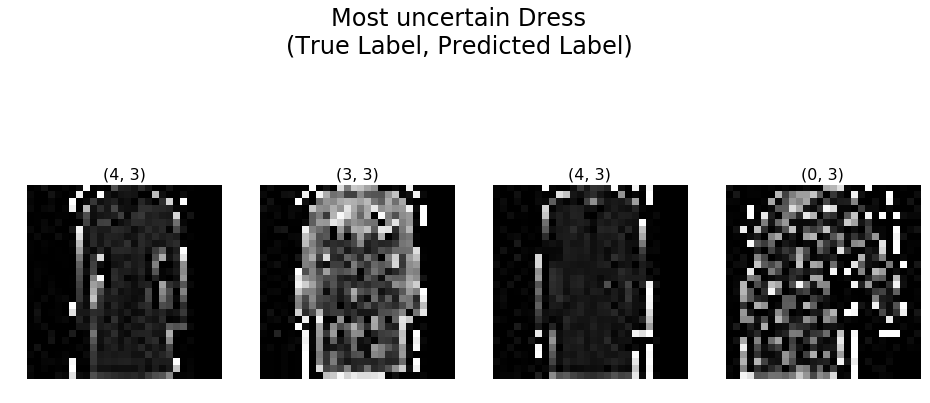

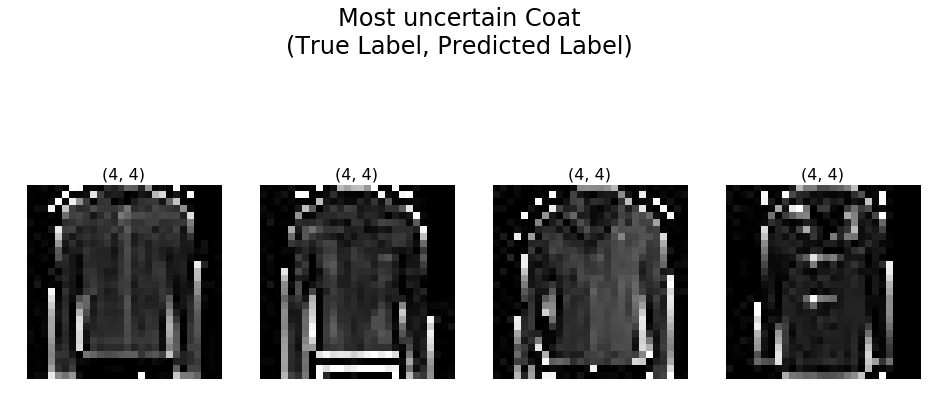

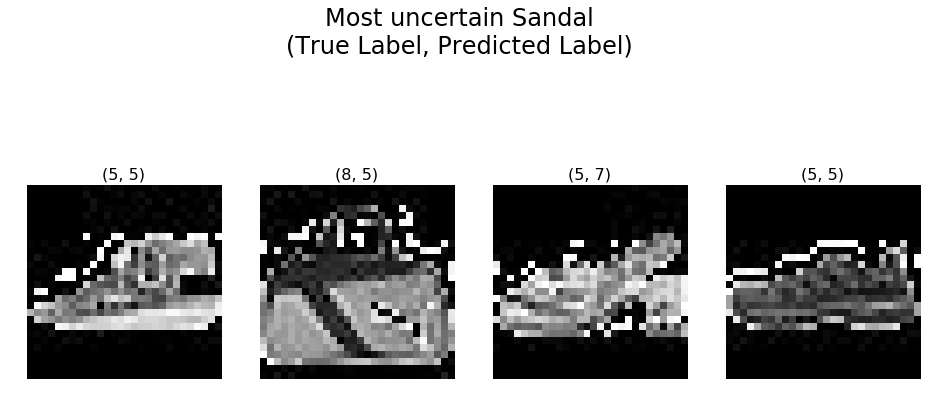

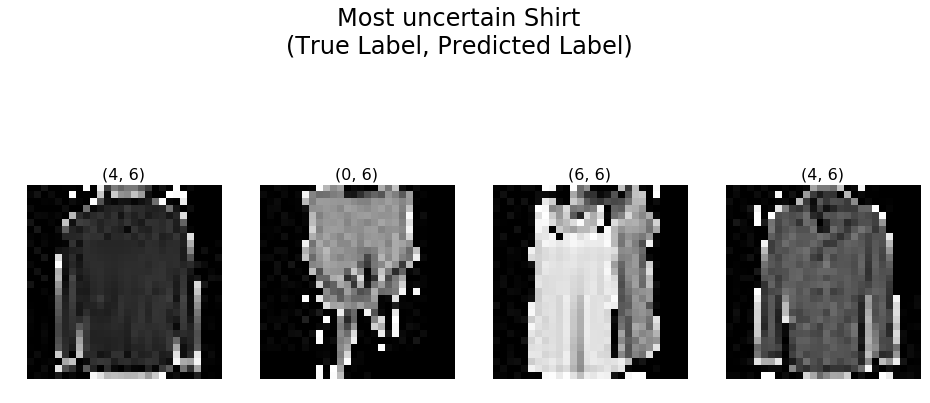

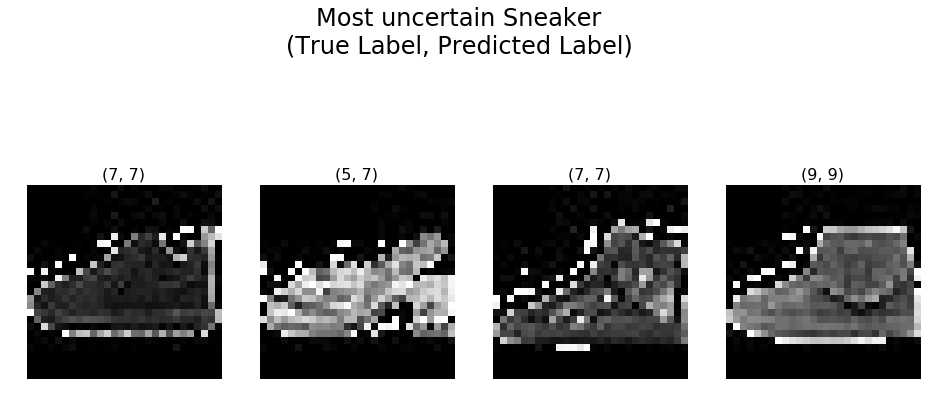

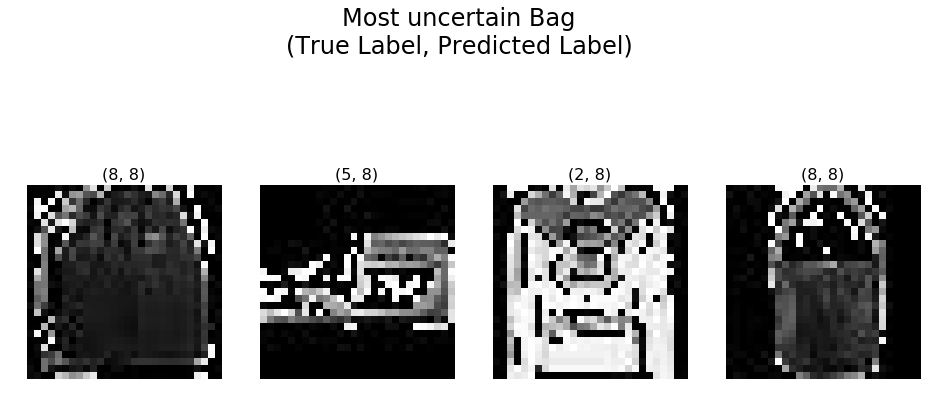

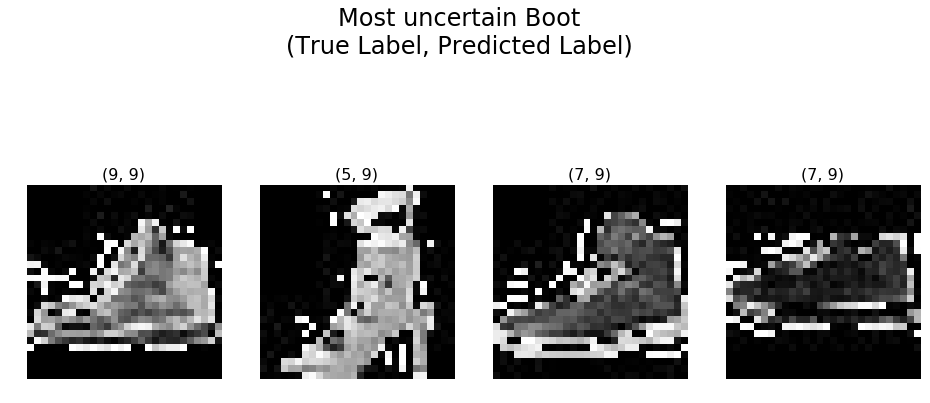

In [37]:
for key, label in labels_dict.items():
    probs = all_probs[key]
    most_uncertain = np.argsort(np.abs(probs-0.5))[:4]
    plot_val_with_title(most_uncertain,
                        "Most uncertain {}".format(label))

## Tuning the Learning Rate

In [36]:
learn = ConvLearner.pretrained(arch, data, precompute=True)


**Finding the best learning rate by increasing it till the loss does not decrease any further**

In [37]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 648/782 [00:30<00:06, 21.59it/s, loss=3.28] 

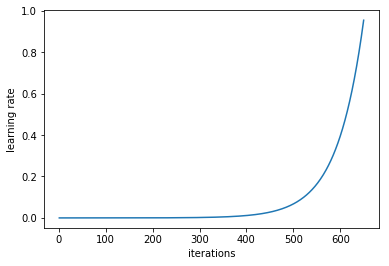

In [38]:
learn.sched.plot_lr()

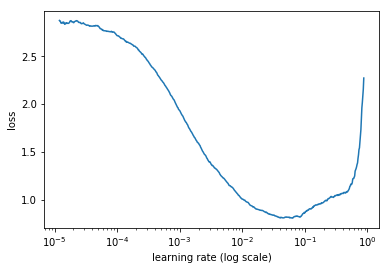

In [39]:
learn.sched.plot()

**We see that the loss stabilises at around 0.1. However, it is still improving at around 0.01.**  

### Learning Rate Experiment: 0.05, 0.001 

In [48]:
lr = 0.05

In [42]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(lr, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

 50%|█████     | 391/782 [00:09<00:09, 42.96it/s, loss=0.625]

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/amanthevinci/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/amanthevinci/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/amanthevinci/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.561684   0.447371   0.834793  
    1      0.509062   0.4164     0.848627                    



[0.41640002, 0.8486265923566879]

**The accuracy didn't change much. However, we find that the loss was still decreasing. Maybe more epochs are required for it to converge**

In [44]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(lr, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.533264   0.456031   0.832205  
    1      0.511457   0.41858    0.848826                    
    2      0.476418   0.401341   0.852309                    



[0.40134063, 0.8523089171974523]

**We see an improvement of 1% in the accuracy with a new epoch. Maybe we can try more.**

In [49]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(lr, 4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.563212   0.44973    0.83758   
    1      0.496929   0.415596   0.84992                     
    2      0.472383   0.409247   0.852607                    
    3      0.440639   0.387531   0.854399                    



[0.38753062, 0.8543988853503185]

**We see no significant improvement by adding another epoch of training.**

In [46]:
lr = 0.001

In [47]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(lr, 4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.767021   0.589015   0.798069  
    1      0.659202   0.526268   0.811803                    
    2      0.623955   0.496948   0.821756                    
    3      0.575266   0.481673   0.827926                    



[0.48167282, 0.8279259554140127]

**The model accuracy worsens on lowering the learning rate. Hence, 0.05 seems to be the optimal learning rate.**

### Report
**Most Optimal Learning Rate: 0.05 [4 Epochs]**  
**Accuracy: 85.4%**


___

## Boosting Model

### 1. Data Augmentation

In [15]:
arch = resnet34

In [16]:
tfms_side = tfms_from_model(arch, size, aug_tfms=transforms_side_on)

In [17]:
def get_augs():
    data=ImageClassifierData.from_paths(DATAPATH, bs=2, tfms=tfms_side)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

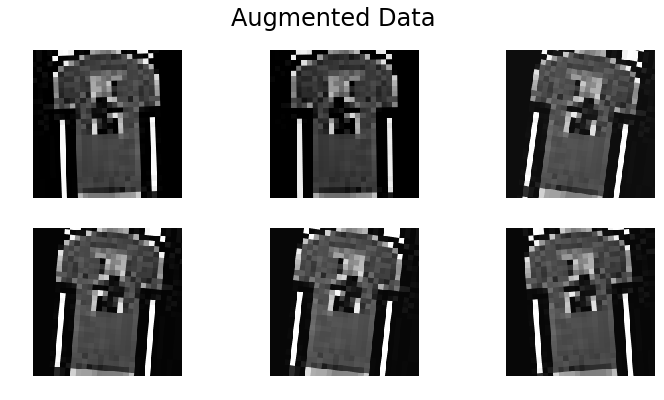

In [18]:
sample_imgs = np.stack([get_augs() for i in range(6)])
plots(sample_imgs, rows=2, main_title='Augmented Data')

**Let's train the model with augmented data**

In [52]:
data = ImageClassifierData.from_paths(DATAPATH, tfms=tfms_side)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [53]:
learn.fit(lrs=[0.05], n_cycle=4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.55603    0.448886   0.83758   
    1      0.503315   0.421493   0.844447  
    2      0.473246   0.400005   0.851413  
    3      0.45005    0.387304   0.857584  



[0.38730374, 0.8575835987261147]

### Report
**Accuracy: 85.7%**  
**Data Augmentation: Side On**

### 2. Turn off Pre-computing

In [54]:
learn.precompute=False

In [56]:
learn.fit(lrs=0.05, n_cycle=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  3%|▎         | 22/782 [00:08<05:03,  2.51it/s, loss=0.521]

Exception in thread Thread-13:
Traceback (most recent call last):
  File "/home/amanthevinci/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/amanthevinci/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/amanthevinci/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy   
    0      0.498462   0.41192    0.847333  
    1      0.484706   0.396026   0.854996  
    2      0.483876   0.394479   0.851115  



[0.39447886, 0.8511146496815286]

### Report:
**Accuracy: 85.1%**  
**Model is underfitting**

### 3. Differential Learning Rate Annealing & SGD with Restarts

In [19]:
tfms_side = tfms_from_model(resnet34, size, aug_tfms=transforms_side_on)

In [20]:
# data = ImageClassifierData.from_paths(DATAPATH, tfms=tfms_from_model(resnet34, size), bs=32)
data = ImageClassifierData.from_paths(DATAPATH, tfms=tfms_side, bs=64)
learn = ConvLearner.pretrained(resnet34, data, precompute=False)
learn.unfreeze()

In [16]:
lr = 0.01
lrs=np.array([lr/100, lr/10, lr])

In [22]:
learn.fit(lrs,6)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.316187   0.276328   0.898388  
    1      0.247906   0.22334    0.917496  
    2      0.199126   0.221353   0.921278  
 19%|█▉        | 149/782 [02:13<09:29,  1.11it/s, loss=0.194]

KeyboardInterrupt: 

**We observe that the model starts overfitting after the second epoch.**

### Optimal Learning Rate

In [17]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 87%|████████▋ | 342/391 [09:40<01:23,  1.70s/it, loss=3.01] 

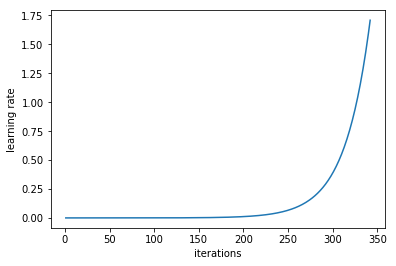

In [18]:
learn.sched.plot_lr()

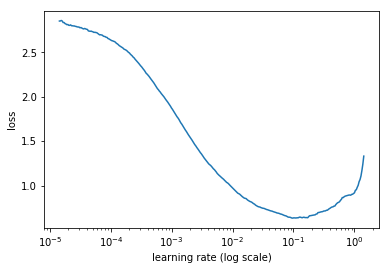

In [19]:
learn.sched.plot()

**Here we see that 0.05 seems to have a steady loss. Since, we will be using learning rate with cosine annealing along with SGD with restarts, a steady learning rate seems a good way to start.**

In [21]:
lr = 0.05
lrs=np.array([lr/100, lr/10, lr])

In [22]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.30598    0.253903   0.906549  
    1      0.253389   0.222747   0.917496                    
    2      0.202417   0.199429   0.929339                    
    3      0.244469   0.202847   0.924562                    
    4      0.188246   0.203684   0.928344                    
    5      0.14492    0.177979   0.938296                    
    6      0.126534   0.17645    0.940486                    



[0.17644995, 0.9404856687898089]

___
## Report:
**Accuracy: 0.94**  
**Possible overfitting**
___

Let's look at the learning rates used...

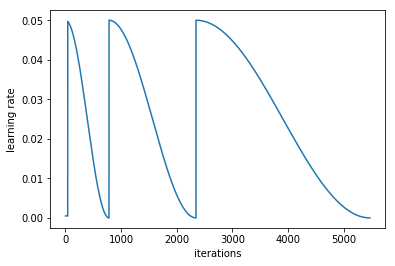

In [29]:
learn.sched.plot_lr()

### Saving the best model

In [31]:
learn.save('resnet34-all')

In [33]:
learn.get_model_path('resnet34-all')

'../data/FashionMNIST/models/resnet34-all.h5'

## Result Analysis

In [34]:
learn.load('resnet34-all')

In [35]:
log_preds, y = learn.TTA()

In [38]:
y.shape, y[-10:]

((10000,), array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9]))

**Due to test time augmentation, we have 5 predictions for every test point. We need to average them.**

In [39]:
log_preds.shape, log_preds[0]

((5, 10000, 10),
 array([[ -0.53572, -11.30532,  -7.60577, ..., -12.46375, -10.70829, -11.04675],
        [ -0.00006, -13.81726,  -9.99408, ..., -16.64869, -13.89941, -17.36814],
        [ -0.00002, -17.41565, -12.85914, ..., -18.24337, -18.08549, -17.01776],
        ...,
        [-21.02241, -20.87825, -23.27331, ...,  -9.28513, -15.83528,  -0.00009],
        [-20.18857, -18.60364, -21.81514, ..., -10.60718, -13.57987,  -0.00003],
        [-14.60273, -11.23279, -16.13147, ...,  -4.16848, -13.58823,  -0.15784]], dtype=float32))

**Finding the final probabilities of all classes in the prediction**

In [40]:
probs = np.mean(np.exp(log_preds), axis=0)
probs.shape, probs[0]

((10000, 10),
 array([0.67607, 0.00001, 0.00079, 0.00028, 0.00007, 0.00002, 0.32272, 0.     , 0.00002, 0.00002],
       dtype=float32))

Sanity Check...

In [49]:
y[9000],probs[9000],np.argmax(probs, axis=1)[9000]

(9,
 array([0.     , 0.00002, 0.     , 0.     , 0.     , 0.00006, 0.     , 0.00004, 0.     , 0.99988],
       dtype=float32),
 9)

In [50]:
preds = np.argmax(probs, axis=1)

**Accuracy**

In [52]:
np.mean(preds==y)

0.9424

### Confusion Matrix

In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
cm

array([[926,   0,  19,  12,   0,   0,  65,   0,   1,   0],
       [  0, 974,   0,  10,   1,   0,   1,   0,   2,   0],
       [  9,   0, 922,   4,  40,   0,  33,   0,   0,   0],
       [  9,   0,   3, 972,  17,   0,  20,   0,   0,   0],
       [  1,   0,  44,  23, 939,   0,  40,   0,   3,   0],
       [  0,   0,   0,   0,   0, 982,   0,  11,   0,   3],
       [ 56,   1,  38,  17,  32,   0, 825,   0,   1,   0],
       [  0,   0,   0,   0,   0,   4,   0, 936,   0,  15],
       [  2,   0,   0,   0,   1,   0,   1,   0, 964,   0],
       [  0,   0,   0,   0,   0,   3,   0,  34,   0, 984]])

[[926   0  19  12   0   0  65   0   1   0]
 [  0 974   0  10   1   0   1   0   2   0]
 [  9   0 922   4  40   0  33   0   0   0]
 [  9   0   3 972  17   0  20   0   0   0]
 [  1   0  44  23 939   0  40   0   3   0]
 [  0   0   0   0   0 982   0  11   0   3]
 [ 56   1  38  17  32   0 825   0   1   0]
 [  0   0   0   0   0   4   0 936   0  15]
 [  2   0   0   0   1   0   1   0 964   0]
 [  0   0   0   0   0   3   0  34   0 984]]


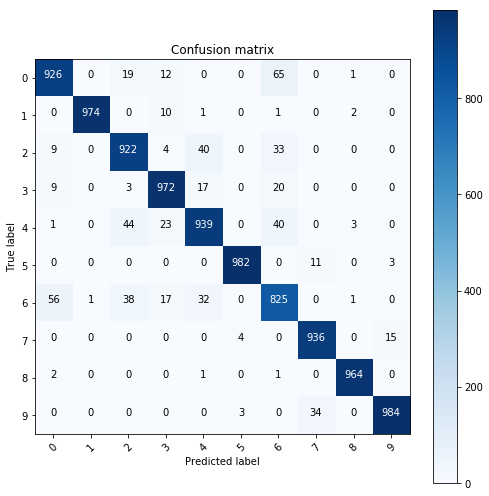

In [57]:
plot_confusion_matrix(cm, data.classes, figsize=(7,7))

### Classification Report

In [60]:
from sklearn.metrics import classification_report
report = classification_report(y, preds)

In [62]:
print(report)

             precision    recall  f1-score   support

          0       0.92      0.91      0.91      1023
          1       1.00      0.99      0.99       988
          2       0.90      0.91      0.91      1008
          3       0.94      0.95      0.94      1021
          4       0.91      0.89      0.90      1050
          5       0.99      0.99      0.99       996
          6       0.84      0.85      0.84       970
          7       0.95      0.98      0.97       955
          8       0.99      1.00      0.99       968
          9       0.98      0.96      0.97      1021

avg / total       0.94      0.94      0.94     10000



## Conclusion
---

1. We have a very coherent f1-score, recall and precision: 94%  
2. Some classes like label:1(trousers) have 100% precision and 99% recall
3. The classs with lowest performance is label:6(shirts)


___